# Part - A :- Document clustering
#### in this part of the assignment, we are asked to derive the Expectation and Maximisation steps forhard EM-algorithm for document clustering which is attached in the pdf report. In this notbook, we implement the hard and soft EM and perform PCA on the clusterings and visualize them on thefirst 2 principal components.


We first begin by loading the required packages.

In [20]:
# You may need to install some packages:
install.packages('tm')
install.packages('SnowballC')


Warning message:
"package 'tm' is in use and will not be installed"

package 'SnowballC' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'SnowballC'"Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying C:\Users\mmoh0064\AppData\Local\Continuum\anaconda3\envs\DAA\Lib\R\library\00LOCK\SnowballC\libs\x64\SnowballC.dll to C:\Users\mmoh0064\AppData\Local\Continuum\anaconda3\envs\DAA\Lib\R\library\SnowballC\libs\x64\SnowballC.dll: Permission denied"Warning message:
"restored 'SnowballC'"


The downloaded binary packages are in
	C:\Users\mmoh0064\AppData\Local\Temp\RtmpOqc7lZ\downloaded_packages


In [22]:
eps=1e-10 # initialize the value for epsilon
  

Axuiliary function to read the text file and split the documents followed by creating a corpus, preprocessing the corpus and returning it as a matrix.

In [21]:
# reading the data
read.data <- function(file.name='dataset/Task2A.txt', sample.size=1000, seed=100, pre.proc=TRUE, spr.ratio= 0.90) {
  # INPUTS:
  ## file.name: name of the input .txt file
  ## sample.size: if == 0  reads all docs, otherwise only reads a subset of the corpus
  ## seed: random seed for sampling (read above)
  ## pre.proc: if TRUE performs the preprocessing (recommended)
  ## spr.ratio: is used to reduce the sparcity of data by removing very infrequent words
  # OUTPUTS:
  ## docs: the unlabled corpus (each row is a document)
  ## word.doc.mat: the count matrix (each rows and columns corresponds to words and documents, respectively)
  ## label: the real cluster labels (will be used in visualization/validation and not for clustering)
  
  # Read the data
  text <- readLines(file.name)
  # select a subset of data if sample.size > 0
  if (sample.size>0){
    set.seed(seed)
    text <- text[sample(length(text), sample.size)]
  }
  ## the terms before the first '\t' are the lables (the newsgroup names) and all the remaining text after '\t' are the actual documents
  docs <- strsplit(text, '\t')
  # store the labels for evaluation
  labels <-  unlist(lapply(docs, function(x) x[1]))
  # store the unlabeled texts    
  docs <- data.frame(doc_id=1:length(docs),text=unlist(lapply(docs, function(x) x[2])))

  library(tm)
  # create a corpus
  docs <- DataframeSource(docs)
  corp <- Corpus(docs)
  
  # Preprocessing:
  if (pre.proc){
    corp <- tm_map(corp, removeWords, stopwords("english")) # remove stop words (the most common word in a language that can be find in any document)
    corp <- tm_map(corp, removePunctuation) # remove pnctuation
    corp <- tm_map(corp, stemDocument) # perform stemming (reducing inflected and derived words to their root form)
    corp <- tm_map(corp, removeNumbers) # remove all numbers
    corp <- tm_map(corp, stripWhitespace) # remove redundant spaces 
  }  
  # Create a matrix which its rows are the documents and colomns are the words. 
  dtm <- DocumentTermMatrix(corp)
  ## reduce the sparcity of out dtm
  dtm <- removeSparseTerms(dtm, spr.ratio)
  ## convert dtm to a matrix
  word.doc.mat <- t(as.matrix(dtm))
  
                                   
  # Return the result
  return (list("docs" = docs, "word.doc.mat"= word.doc.mat, "labels" = labels))
}

We now read the dataset using the auxiliary function defined above.

In [7]:
data <- read.data(file.name='Task2A.txt', sample.size=0, seed=100, pre.proc=TRUE, spr.ratio= .99)

We now build a helper logsum function which converts the computation to log space and converts the results back to numerical spaceusig exp function to reduce the numerical errors.

In [23]:
## --- helper function ------------------------------------------------------------------ 
logSum <- function(v) {
   m = max(v)
   return ( m + log(sum(exp(v-m))))
}

In [24]:
##--- Initialize model parameters randomly --------------------------------------------
initial.param <- function(vocab_size, K=4, seed=123456){
  rho <- matrix(1/K,nrow = K, ncol=1) # assume all clusters have the same size (we will update this later on)
  mu <- matrix(runif(K*vocab_size),nrow = K, ncol = vocab_size) # initiate Mu 
  mu <- prop.table(mu, margin = 1) # normalization to ensure that sum of each row is 1
  return (list("rho" = rho, "mu"= mu))
}

We now build the Expectation function for soft clustering. We basically perform the following steps,
- Calucate posterior prbability which is nothing but $\gamma_{n,k}$ in log space.
- Normalize $\gamma_{n,k}$ to 1.
- convert back to numerical space from log space using exp function

In [25]:
#Expectation function for Soft Max
Esoft.step <- function(gamma, model, counts){
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  K <- dim(model$mu)[1]

  # E step:    
  for (n in 1:N){
    for (k in 1:K){
      ## calculate the posterior based on the estimated mu and rho in the "log space"
      gamma[n,k] <- log(model$rho[k,1]) +  sum(counts[,n] * log(model$mu[k,])) 
    }
    # normalisation to sum to 1 in the log space
    logZ = logSum(gamma[n,])
    gamma[n,] = gamma[n,] - logZ
  }
  
  # converting back from the log space 
  gamma <- exp(gamma)
  return (gamma)
}

We now build an Expectation function for hard clustering. It basically performs the following steps,
- Calucate posterior prbability which is nothing but $\gamma_{n,k}$ in log space.
- Normalize $\gamma_{n,k}$ to 1.
- Calculate the maximum probability of a datapoint belonging to a particular cluster and set that to 1 and remaining to 0.

In [10]:
#Expectation function for Hard Max
Ehard.step <- function(gamma, model, counts){
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  K <- dim(model$mu)[1]
  # E step:    
  for (n in 1:N){
    for (k in 1:K){
      ## calculate the posterior based on the estimated mu and rho in the "log space"
      gamma[n,k] <- log(model$rho[k,1]) +  sum(counts[,n] * log(model$mu[k,])) 
    }
    # normalisation to sum to 1 in the log space
    
    logZ = logSum(gamma[n,])
    gamma[n,] = gamma[n,] - logZ
    
  
  }
  #hard EM
  # Asssign 1 to the cluster which it belongs to zero to rest of them
    max.prob <- gamma==apply(gamma, 1, max) # for each point find the cluster with the maximum (estimated) probability
    gamma[max.prob] <- 1 # assign each point to the cluster with the highest probability
    gamma[!max.prob] <- 0 

    return (gamma)
}

We now build the maximisation function. We do the following,
- Get the model parameter setting i.e number of documents, words, clusters, Rho and mu whichis the probability the word belonging to a cluster.
- We then iterate through all clusters to get the effective number of points in each cluster which is $N_{k}$
- We then iterate through our vocabulary to calculate the probability of a word belonging to all clusters. We add epsilon to avoid NA values
- We assign the probability to each cluster and normalize this to 1.
- we finally return the model.

In [26]:
M.step <- function(gamma, model, counts){
    
  # Model Parameter Setting
  N <- dim(counts)[2]   # number of documents
  W <- dim(counts)[1]   # number of words i.e. vocabulary size
  K <- dim(model$mu)[1] # number of clusters
  Nk.hat <- model$rho # Rho old
  mu <- model$mu  # probability each word belonging to a cluster

 for (k in 1:K){
        
        # the effective number of point in cluster k divided by total number of points
        
      
        Nk.hat[k]<-sum(gamma[,k])/N 
     for (w in 1:W)
        {     
           # calculate probability of each word belonging to the all three clusters
           # add eps to avoid NA values
            val<-(counts[w,] * gamma[,k]) + eps
            mu[k,w]<-sum(val* gamma[,k])/(sum(counts * gamma[,k])+K*eps)
          
          
       }
      
    }
    # assign that probability of each cluster
    model$rho<-Nk.hat
   
   
#NORMALIZE it to one 
model$mu<-prop.table(mu, margin = 1)
    
    
  
# Return the result
return (model)
}

We now perform EM for soft clustering. 
- We begin with setting model parameters, i.e. getting number of documents, unique words and initializing the model and gamma
- We now build the model and make it run for 10 epochs.
- For each epoch, we calculate the $\gamma$ using Esoft function implemented above.
- We then maximize it using the M function iplemented above.
- We do it iteratively till the maximum number of epoches is reached and return the final model.

In [27]:
##--- EM for Document Clustering --------------------------------------------
EM_soft <- function(counts, K=4, max.epoch=10, seed=123456){
  #INPUTS:
  ## counts: word count matrix
  ## K: the number of clusters
  #OUTPUTS:
  ## model: a list of model parameters
  
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  W <- dim(counts)[1] # number of unique words (in all documents)
  
  # Initialization
  model <- initial.param(W, K=K, seed=seed)
  gamma <- matrix(0, nrow = N, ncol = K)

  print(train_obj(model,counts))
  # Build the model
  for(epoch in 1:max.epoch){
    
    # E Step
    gamma <- Esoft.step(gamma, model, counts)
    # M Step
    model <- M.step(gamma, model, counts)
   
    print(train_obj(model,counts)) 
  }
  # Return Model
  return(list("model"=model,"gamma"=gamma))
}

We perform the same for hard clustering as done in soft clustering except we replace the expectation function for soft clustering with hard clustering.

In [28]:
##--- EM for Document Clustering --------------------------------------------
EM_hard <- function(counts, K=4, max.epoch=10, seed=123456){
  #INPUTS:
  ## counts: word count matrix
  ## K: the number of clusters
  #OUTPUTS:
  ## model: a list of model parameters
  
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  W <- dim(counts)[1] # number of unique words (in all documents)
  
  # Initialization
  model <- initial.param(W, K=K, seed=seed)
  gamma <- matrix(0, nrow = N, ncol = K)

  print(train_obj(model,counts))
  # Build the model
  for(epoch in 1:max.epoch){
    
    # E Step
    gamma <- Ehard.step(gamma, model, counts)
    # M Step
    model <- M.step(gamma, model, counts)
   
    print(train_obj(model,counts)) 
  }
  # Return Model
  return(list("model"=model,"gamma"=gamma))
}

We now build the negative log-likelihood function as our training objective which calculates the negative log likelihood of the counts belonging to the model.We then create a cluster visualization function for visualizing the clusters.

In [29]:
##--- the training objective function --------------------------------------------
# Input: 
#    model:  the model object containing the mu and rho
#    counts: the word-document frequency matrix
# Output:
#    nloglike: the negative log-likelihood i.e. log P(counts|model) 
#   
train_obj <- function(model, counts) { 
  N <- dim(counts)[2] # number of documents
  K <- dim(model$mu)[1]
   
  nloglike = 0
  for (n in 1:N){
    lprob <- matrix(0,ncol = 1, nrow=K)
    for (k in 1:K){
      lprob[k,1] = sum(counts[,n] * log(model$mu[k,])) 
    }
    nloglike <- nloglike - logSum(lprob + log(model$rho))
  }
  
  return (nloglike)
}

##--- Cluster Visualization -------------------------------------------------
cluster.viz <- function(doc.word.mat, color.vector, title=' '){
  p.comp <- prcomp(doc.word.mat, scale. = TRUE, center = TRUE)
  plot(p.comp$x, col=color.vector, pch=1,  main=title)
}

We now the store the results for hard clustering from EM_hard and pass it to cluster.viz which visualizes the clusters.

[1] 2180904
[1] 1949401
[1] 1931138
[1] 1922048
[1] 1918474
[1] 1916824


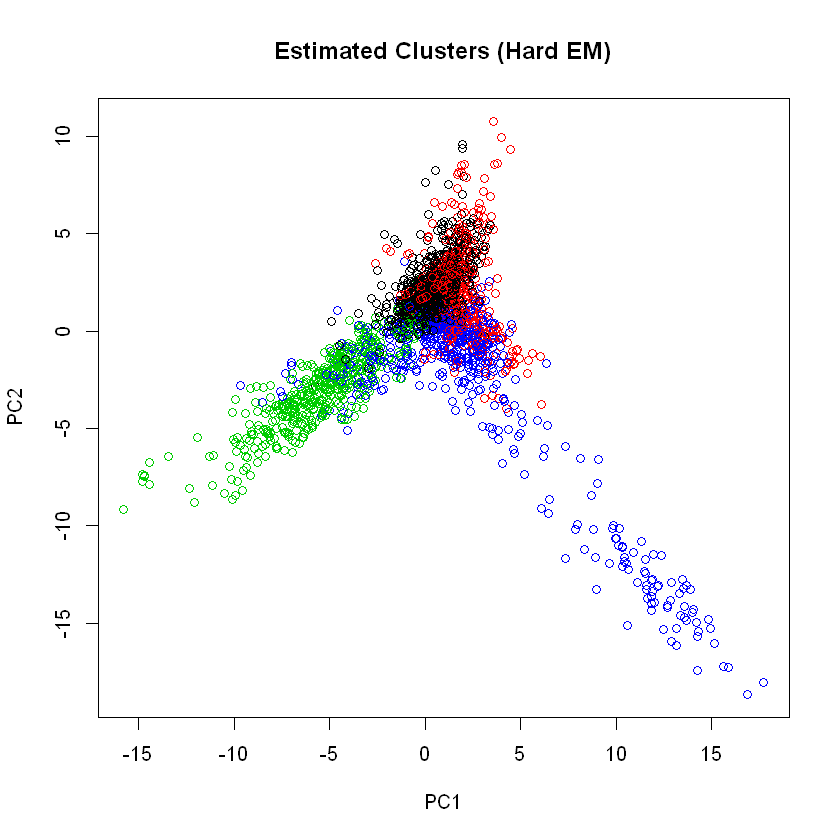

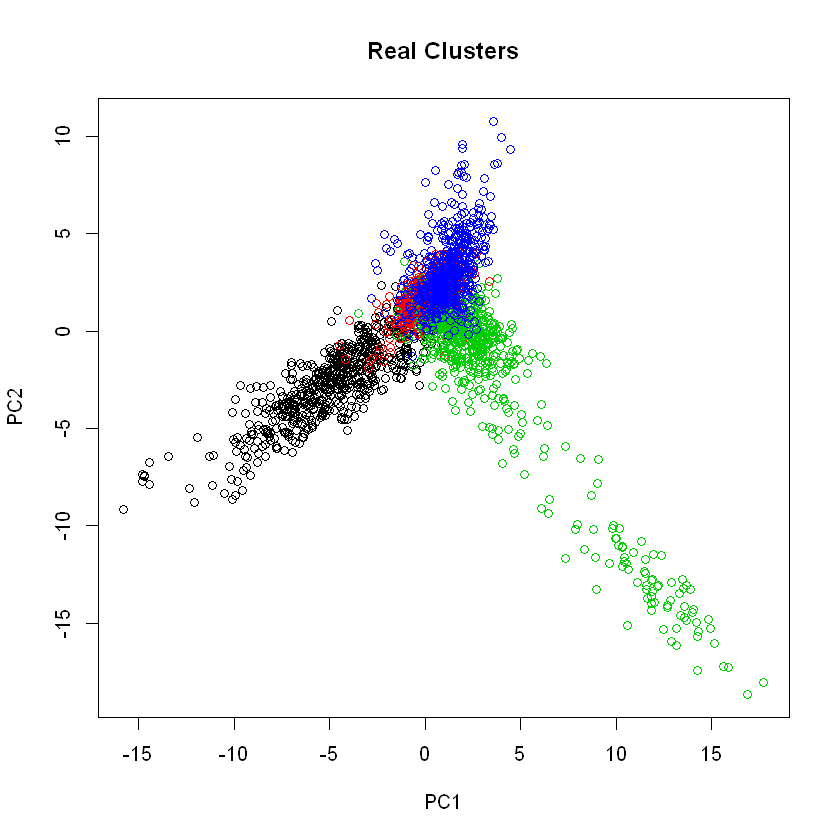

In [30]:
# word-document frequency matrix 
counts <- data$word.doc.mat 

# below is toy data if you want to work with
#counts <- matrix(c(1,1,0,1,0,0,0,1,1,1,0,1,0,0,1,1,0,0),nrow=3,ncol=6)
# calling the EM algorithm on the data
res <- EM_hard(counts, K=4, max.epoch=5)   

# visualization
## find the culster with the maximum probability (since we have soft assignment here)
label.hat <- apply(res$gamma, 1, which.max) 
## normalize the count matrix for better visualization
counts<-scale(counts) # only use when the dimensionality of the data (number of words) is large enough
## visualize the estimated clusters
cluster.viz(t(counts), label.hat, 'Estimated Clusters (Hard EM)')

## visualize the real clusters
cluster.viz(t(counts), factor(data$label), 'Real Clusters')

We do the same below for soft clustering.

[1] 2170696
[1] 1950012
[1] 1935135
[1] 1923313
[1] 1917463
[1] 1914809


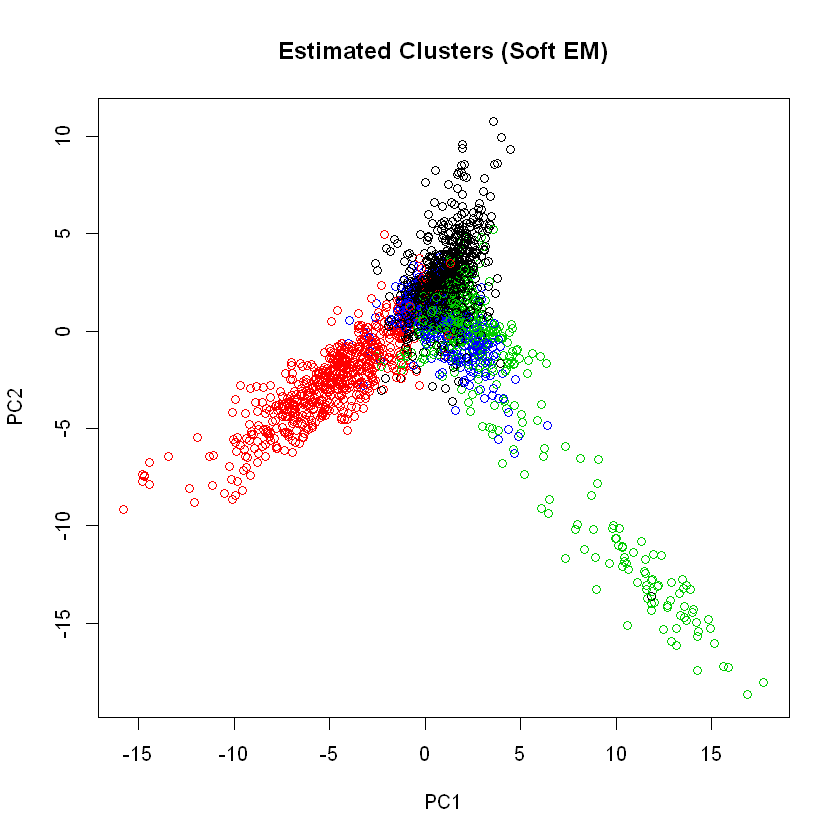

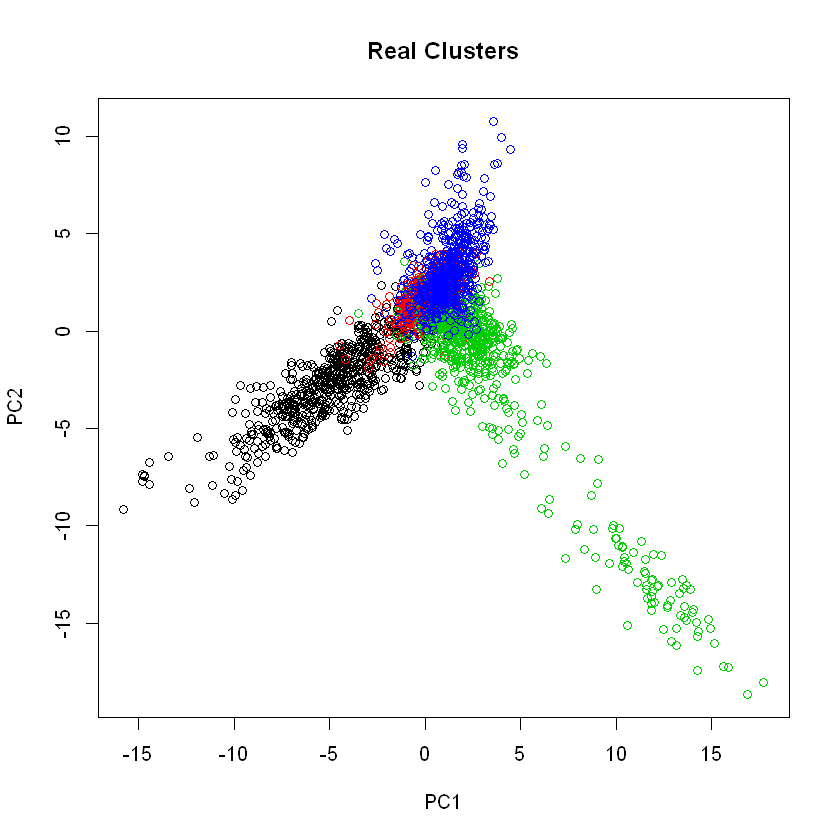

In [31]:
# word-document frequency matrix 
counts <- data$word.doc.mat 

# below is toy data if you want to work with
#counts <- matrix(c(1,1,0,1,0,0,0,1,1,1,0,1,0,0,1,1,0,0),nrow=3,ncol=6)
# calling the EM algorithm on the data
res <- EM_soft(counts, K=4, max.epoch=5)   

# visualization
## find the culster with the maximum probability (since we have soft assignment here)
label.hat <- apply(res$gamma, 1, which.max) 
## normalize the count matrix for better visualization
counts<-scale(counts) # only use when the dimensionality of the data (number of words) is large enough
## visualize the estimated clusters
cluster.viz(t(counts), label.hat, 'Estimated Clusters (Soft EM)')

## visualize the real clusters
cluster.viz(t(counts), factor(data$label), 'Real Clusters')